In [10]:
from helpers import bert_helper, datasets, grinders, helpers

import os, shutil
import csv
import pickle

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib notebook

"""
Resources used 

 -  https://stackoverflow.com/questions/38197964/pandas-plot-multiple-time-series-dataframe-into-a-single-plot
 -  https://stackoverflow.com/questions/8389636/creating-over-20-unique-legend-colors-using-matplotlib
"""

def read_results():
    # get the data
    results_file = '../data/concreteness_simlex_analysis_results_simlex_2020-05-03.csv'
    fieldnames = ['layer', 'k_clusters', 'pearson', 'pearson_P', 'spearman', 'spearman_P', 'N']

    with open(results_file, mode='r') as disk:
        reader = csv.DictReader(disk, delimiter='\t', fieldnames=fieldnames)

        data = [row for row in reader]
        for row in data:
            row['spearman'] = float(row['spearman'])
            row['layer'] = int(row['layer'])
        df = pd.DataFrame.from_records(data, coerce_float=True)
        return df

def plot_axis(ax, dataset, df):


        #sns.heatmap(df, cmap='RdYlGn_r', linewidths=0.5, annot=True)
        
        #ax.set_xlabel('Number of K-Means Clusters')
        #ax.set_ylabel('Spearman Correlation')
        # multiline plot with group by
        for key, grp in df.groupby(['layer']): 
            ax.plot(grp['k_clusters'], grp['spearman'], label = "Layer {}".format(key), color=cm(1.*key/NUM_COLORS))
            ax.set_title(dataset)
"""
Global Parameters
"""
# Change default color cycle for all new axes
NUM_COLORS = 12
cm = plt.get_cmap('gist_rainbow')
#mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["r", "k", "c"]) 


"""
similarity datasets
"""


#plt.figure(1)
# fig1, (ax1) = plt.subplots(nrows = 1, ncols = 1)
# fig1.text(0.5, 0.04, 'Number of K-Means Clusters', ha='center', va='center')
# fig1.text(0.06, 0.5, 'Spearman Correlation', ha='center', va='center', rotation='vertical')


# datasets = ['simlex']
# #similarity_measure = 'max_sim'
# axes = [ax1]
# zipp = zip(datasets, axes)

# for dataset, ax in zipp:
#     data = read_results()
#     ax.set_title('Relationship between average within-cluster variance\n and USF concreteness norms of words in SimLex999')
#     plot_axis(ax, dataset, data)
# plt.legend(bbox_to_anchor=(1.3, 1.3))
# #plt.legend(loc='lower right')    
# plt.tight_layout()




"""
break out by POS
"""


def read_pos_results():
    results_file = '../data/concreteness_simlex_analysis_results_simlex_pos_2020-05-04.csv'
    fieldnames = ['layer', 'k_clusters', 'POS', 'pearson', 'pearson_P', 'spearman', 'spearman_P', 'N']

    with open(results_file, mode='r') as disk:
        reader = csv.DictReader(disk, delimiter='\t', fieldnames=fieldnames)

        data = [row for row in reader]
        for row in data:
            row['spearman'] = float(row['spearman'])
            row['spearman_P'] = float(row['spearman_P'])
            row['layer'] = int(row['layer'])
        df = pd.DataFrame.from_records(data, coerce_float=True)
        return df

#plt.figure(1)


simlex = datasets.get_simlex999()

words = []
for row in simlex:
    pos = row['POS']

    w1 = row['word1']
    w1_conc = row['conc_w1']
    words.append({'word': w1, 'concreteness': w1_conc, 'POS': pos})
    w2 = row['word2']
    w2_conc = row['conc_w2']
    words.append({'word': w2, 'concreteness': w2_conc, 'POS': pos})

words = [dict(t) for t in {tuple(d.items()) for d in words}]


poses = ['N', 'A', 'V']
dataset = 'simlex'
similarity_measure = 'max_sim'

fig1, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1)
fig1.text(0.5, 0.04, 'USF concreteness rating', ha='center', va='center')
fig1.text(0.06, 0.5, 'BERT-cloud Variance', ha='center', va='center', rotation='vertical')


axes = [ax1, ax2, ax3]
zipp = zip(poses, axes)




for pos, ax in zipp:


    for row in words:
        word = row['word']


        var_for_all_cluster_ids = helpers.read_variance_for_word_at_layer_and_cluster(word, 8, 1)

        if var_for_all_cluster_ids is not None:
            var = np.average(var_for_all_cluster_ids)
            row['within_cluster_variance'] = var

    filtered_data = list(filter(lambda row: row['within_cluster_variance'] != None, words))

    data = pd.DataFrame.from_records(filtered_data)

    #data = read_pos_results()
    data = data[data['POS'] == pos]
    #data = data[data['layer'] == 0]
    #print(data)


    X = data['concreteness']
    y = data['within_cluster_variance']
    
    
    names = data['word']
    #c = np.random.randint(len(data))
    
    print(data)
    ax.scatter(X,y, c=names)
    ax.set_title(pos)
    
    #data = data[data['spearman_P'] < 0.10]
    print(len(data))
    #plot_axis(ax, pos, data)
    
    
    annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

plt.legend(bbox_to_anchor=(1.0, 1.8))
#plt.legend(loc='lower right')    





def update_annot(ind):

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
                           " ".join([names[n] for n in ind["ind"]]))    
    text = ind
    annot.set_text(text)
    #annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)


# # print it all out
plt.show()

processed 999 word pairs from simlex999 dataset


<IPython.core.display.Javascript object>

AttributeError: module 'helpers.helpers' has no attribute 'read_variance_for_word_at_layer_and_cluster'

In [9]:
from helpers import bert_helper, datasets, grinders, helpers

import os, shutil
import csv
import pickle

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

%matplotlib notebook


def get_spearman_results_for(dataset):
    results_file = '../data/multilayer_and_cluster_analysis_results_'+dataset+ '_'+'2020-07-14'+'.csv'
    fieldnames = ['dataset', 'similarity_measure', 'layer', 'k_clusters', 'pearson', 'pearson_P', 'spearman', 'spearman_P', 'N']
    with open(results_file, mode='r') as disk:
        reader = csv.DictReader(disk, delimiter='\t', fieldnames=fieldnames)
        
        data = [row for row in reader]

        for row in data:
            row['spearman'] = float(row['spearman'])
            row['layer'] = int(row['layer'])
            row['k_clusters'] = int(row['k_clusters'])
        df = pd.DataFrame.from_records(data, coerce_float=True)

        return df


def get_table_data_for(dataset, sim_measure):
    df = get_spearman_results_for(dataset) 
    df = df[df['similarity_measure'] == sim_measure]

    df = df.pivot(index='k_clusters', columns='layer', values='spearman')
    df = df.round(3)
    #df.style.format("{:.3%}")
    #pd.options.display.float_format = '${:,.2f}'.format

    print(df)
    print("dataset %s" % dataset)
    print("sim measure %s" % sim_measure)
    #return df.to_csv(quoting=csv.QUOTE_ALL)
    return df


def heatmap(dataset, sim_measure,i):
        res = get_table_data_for(dataset, sim_measure)
        sns.heatmap(res, cmap="YlGnBu")
        plt.figure(i)
        f, ax = plt.subplots()
        sns.heatmap(res, annot=True, fmt='.3f', linewidths=.5, ax=ax, cmap="YlGnBu", square=False)
        #display(f)

similarity_measures = ['max_sim', 'avg_sim']
# datasets = {'ws_353': ws353, 
#             'ws353_rel': ws353_rel,  
#             'simlex': simlex, 
#             'verbsim': verbsim, 
#             'men': men }
datasets = ['ws_353', 'ws353_rel', 'simlex', 'verbsim', 'men']

sns.set()

# res = get_table_data_for('simlex', 'max_sim')

# f, ax = plt.subplots(figsize=(9, 6))
# sns.heatmap(res, annot=True, fmt='.3f', linewidths=.5, ax=ax, cmap="YlGnBu", square=False)
# plt.show()
#print(res.to_csv())

# i=0
# for s in similarity_measures:
#     for d in datasets:
#         heatmap(d,s,i)
#         i+=1


layer          0      1      2      3      4      5      6      7      8   \
k_clusters                                                                  
1           0.694  0.689  0.671  0.639  0.626  0.628  0.636  0.647  0.657   
2           0.699  0.700  0.681  0.645  0.643  0.646  0.647  0.662  0.677   
3           0.705  0.704  0.682  0.656  0.658  0.658  0.650  0.666  0.687   
4           0.711  0.706  0.681  0.646  0.653  0.659  0.649  0.661  0.685   
5           0.710  0.706  0.674  0.643  0.650  0.654  0.655  0.666  0.695   
6           0.705  0.694  0.680  0.642  0.642  0.651  0.645  0.667  0.702   
7           0.703  0.696  0.678  0.634  0.645  0.647  0.651  0.669  0.700   
8           0.702  0.696  0.675  0.628  0.631  0.651  0.642  0.664  0.681   
9           0.701  0.696  0.667  0.617  0.624  0.632  0.645  0.659  0.689   
10          0.698  0.681  0.662  0.625  0.603  0.613  0.637  0.659  0.689   
50          0.703  0.688  0.639  0.587  0.570  0.593  0.617  0.642  0.675   

<IPython.core.display.Javascript object>


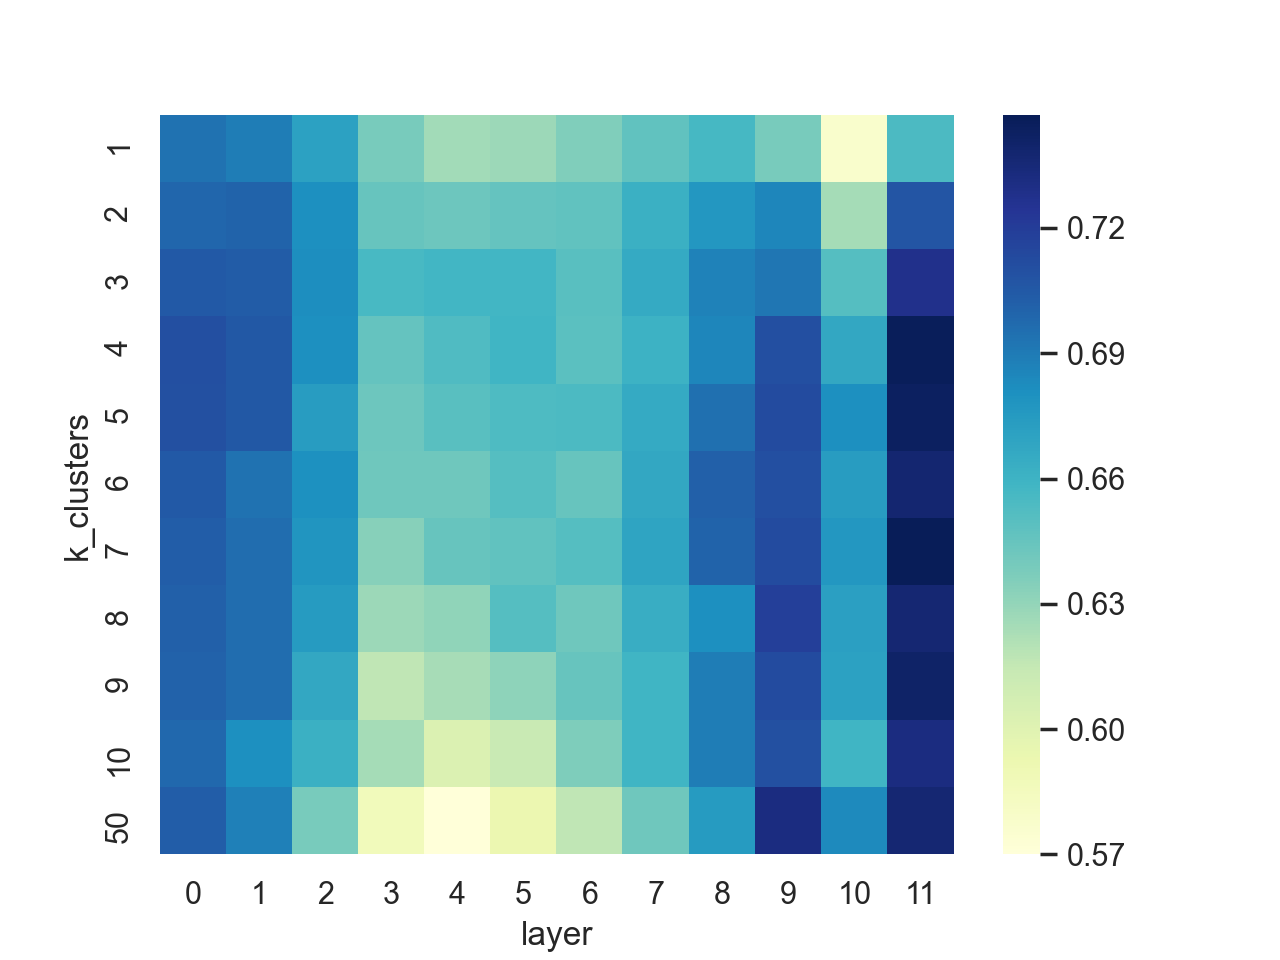

<IPython.core.display.Javascript object>


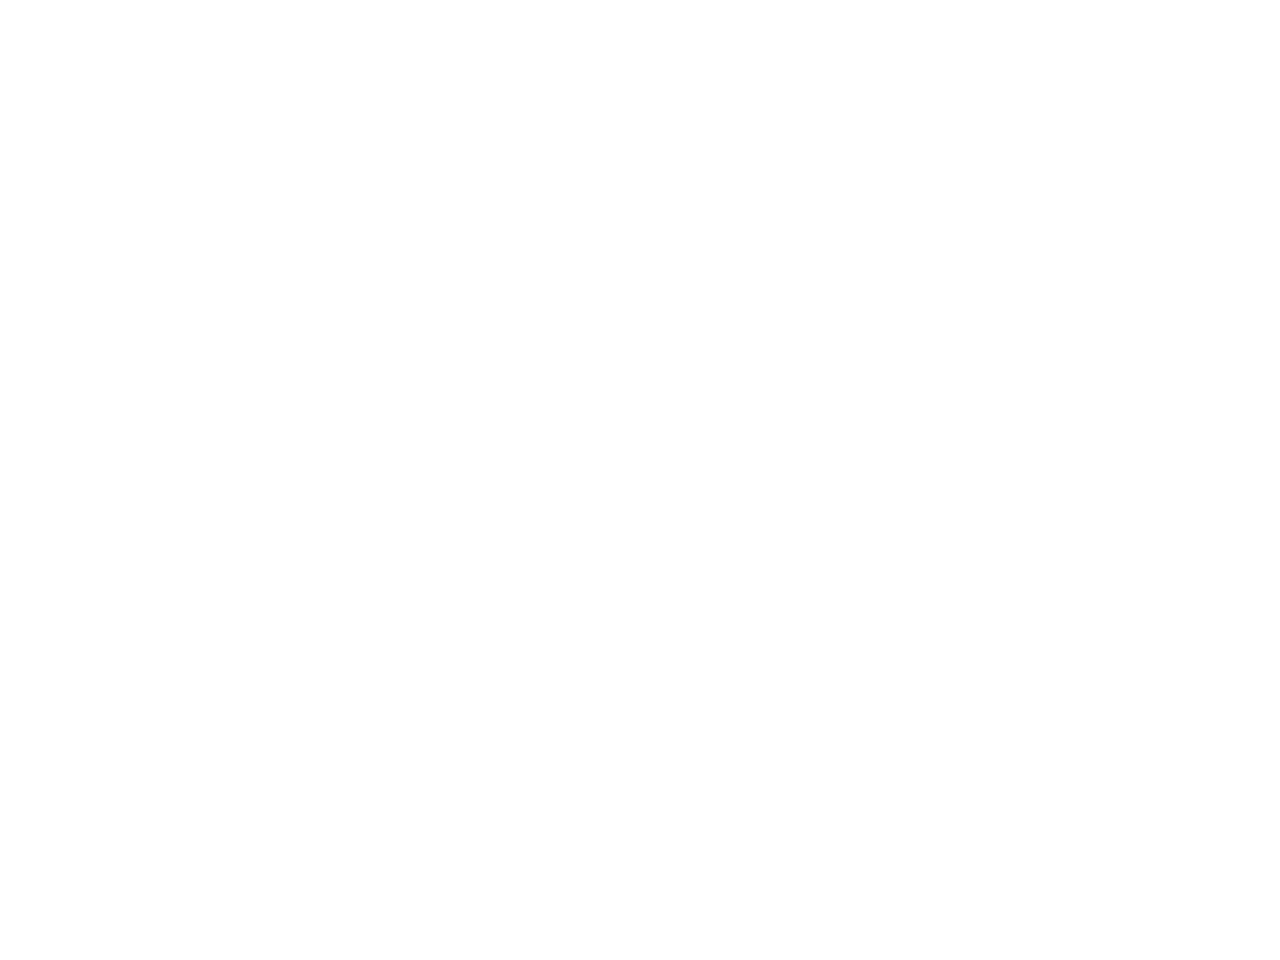

<IPython.core.display.Javascript object>


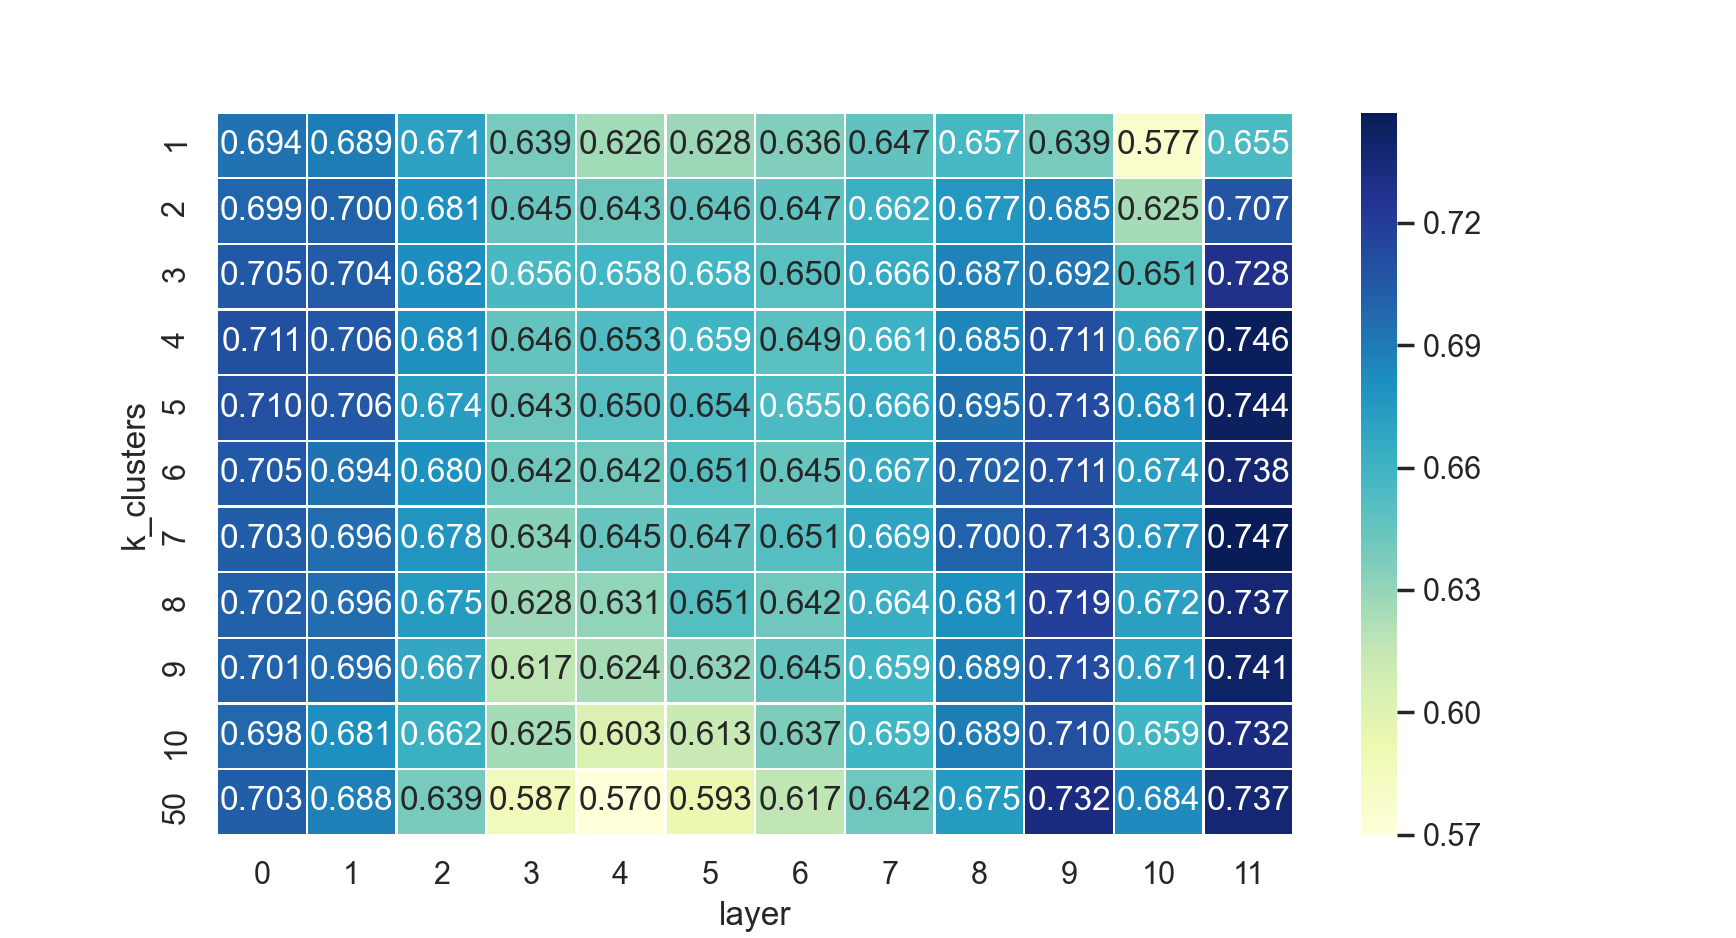

In [8]:
d = 'ws353'
s = 'max_sim'
heatmap(d,s, 0)